In [1]:
import os
os.chdir('/home/jupyter-nafisha/normal-abnormal-multitask/main')

In [2]:
import torch
import torch.nn as nn
from dataset import XrayDataset
from torch.utils.data import DataLoader
from transform import train_transform
from multimodel import Multimodel

In [3]:
# pwd

In [4]:
csv_path = '/home/jupyter-nafisha/normal-abnormal-multitask/CSVs/train.csv'
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [5]:
train_dataset = XrayDataset(img_dir='/home/common/data_v3', csv_path=csv_path, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

In [6]:
for image, disease_id, label, bbox, has_bbox in train_loader:
    image, disease_id, label, bbox, has_bbox = image, disease_id, label, bbox, has_bbox
    break

In [7]:
image.shape, label.shape, bbox, has_bbox

(torch.Size([4, 3, 224, 224]),
 torch.Size([4]),
 tensor([[   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [1003.,  482., 1409.,  967.],
         [   0.,    0.,    0.,    0.]]),
 tensor([False, False,  True, False]))

In [8]:
disease_id, label, bbox, has_bbox

(tensor([0, 0, 2, 0]),
 tensor([0., 0., 1., 0.]),
 tensor([[   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [1003.,  482., 1409.,  967.],
         [   0.,    0.,    0.,    0.]]),
 tensor([False, False,  True, False]))

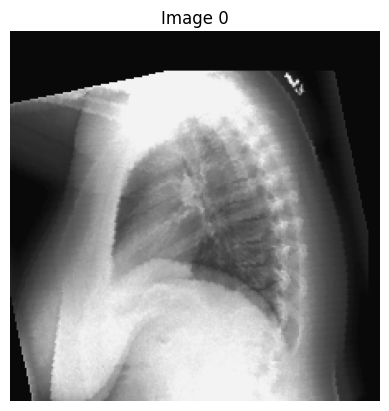

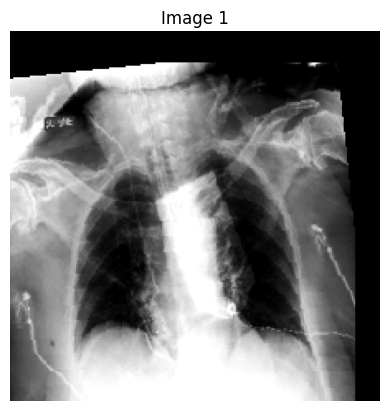

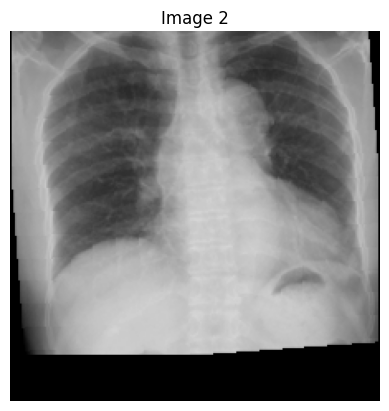

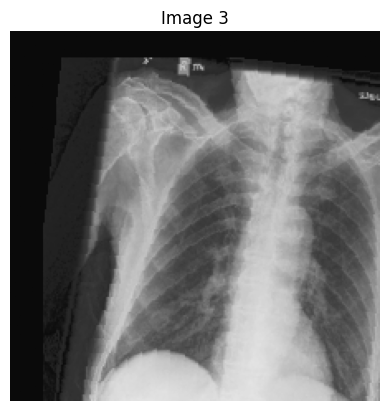

In [9]:
import matplotlib.pyplot as plt

# batch: torch.Tensor of shape [4, 3, 224, 224]
batch = image.cpu()   # make sure it's on CPU

for i in range(batch.shape[0]):
    img = batch[i].permute(1, 2, 0)  # CHW → HWC

    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Image {i}")
    plt.show()


In [11]:
model = Multimodel().to(device)

/home/jupyter-nafisha/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-nafisha/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
image = image.to(device)
label = label.to(device)
bbox  = bbox.to(device)
has_bbox = has_bbox.to(device)

In [13]:
bbox

tensor([[1037., 1056., 2158., 1578.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.]])

In [14]:
criterian = nn.BCEWithLogitsLoss()
bbox_loss = nn.MSELoss(reduction="none")

In [15]:
# model

In [18]:
cls_logits, bbox_preds = model(image, disease_id, return_bbox=True)

In [19]:
cls_logits, bbox_preds

(tensor([[-0.0624],
         [ 0.0246],
         [-0.0562],
         [-0.0964]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.1765, -0.3004,  0.1495,  0.0473],
         [ 0.0163, -0.0589,  0.0356,  0.1213],
         [ 0.0079,  0.0601,  0.3590,  0.2417],
         [ 0.1806,  0.0337,  0.2601,  0.5784]], grad_fn=<AddmmBackward0>))

In [20]:
cls_logits = model(image)
cls_logits

tensor([[ 0.1933],
        [-0.1366],
        [-0.0659],
        [-0.0649]], grad_fn=<AddmmBackward0>)

In [21]:
bbox_preds.shape, bbox.shape

(torch.Size([4, 4]), torch.Size([4, 4]))

In [22]:
loss_bbox = bbox_loss(bbox_preds, bbox)

In [23]:
loss_bbox

tensor([[1.0750e+06, 1.1158e+06, 4.6563e+06, 2.4899e+06],
        [2.6687e-04, 3.4694e-03, 1.2663e-03, 1.4706e-02],
        [6.2179e-05, 3.6169e-03, 1.2891e-01, 5.8413e-02],
        [3.2605e-02, 1.1329e-03, 6.7653e-02, 3.3459e-01]],
       grad_fn=<MseLossBackward0>)

In [24]:
loss_bbox

tensor([[1.0750e+06, 1.1158e+06, 4.6563e+06, 2.4899e+06],
        [2.6687e-04, 3.4694e-03, 1.2663e-03, 1.4706e-02],
        [6.2179e-05, 3.6169e-03, 1.2891e-01, 5.8413e-02],
        [3.2605e-02, 1.1329e-03, 6.7653e-02, 3.3459e-01]],
       grad_fn=<MseLossBackward0>)

In [25]:
mask = has_bbox.unsqueeze(1).float()
print(mask)
loss_bbox = (loss_bbox * mask).sum() / mask.sum()

tensor([[1.],
        [0.],
        [0.],
        [0.]])


In [26]:
loss_bbox

tensor(9337028., grad_fn=<DivBackward0>)

In [27]:
loss_bbox

tensor(9337028., grad_fn=<DivBackward0>)

In [28]:
cls_logits.shape, label.shape

(torch.Size([4, 1]), torch.Size([4]))

In [29]:
label

tensor([1., 0., 0., 0.])

In [30]:
preds = (torch.sigmoid(cls_logits).squeeze(1) > 0.5).float()
preds

tensor([1., 0., 0., 0.])

In [31]:
total_correct = (preds == label).sum().item()

In [32]:
preds == label

tensor([True, True, True, True])

In [10]:
import shutil
dir_path = '/home/jupyter-nafisha/chexAgent-Normal-Abnormal/test_orig_CLAHE'
shutil.make_archive(dir_path, 'zip', dir_path)

'/home/jupyter-nafisha/chexAgent-Normal-Abnormal/test_orig_CLAHE.zip'

In [8]:
pwd

'/home/jupyter-nafisha/normal-abnormal-multimodel'

In [9]:
DISEASES = [
    'no_bbox',
    'No finding',
    'Aortic enlargement',
    'Atelectasis',
    'Calcification',
    'Cardiomegaly',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Nodule/Mass',
    'Other lesion',
    'Pleural effusion',
    'Pleural thickening',
    'Pneumothorax',
    'Pulmonary fibrosis'
]

In [10]:
disease2id = {disease: idx for idx, disease in enumerate(DISEASES)}
id2disease = {idx: disease for disease, idx in disease2id.items()}

In [11]:
disease2id

{'no_bbox': 0,
 'No finding': 1,
 'Aortic enlargement': 2,
 'Atelectasis': 3,
 'Calcification': 4,
 'Cardiomegaly': 5,
 'Consolidation': 6,
 'ILD': 7,
 'Infiltration': 8,
 'Lung Opacity': 9,
 'Nodule/Mass': 10,
 'Other lesion': 11,
 'Pleural effusion': 12,
 'Pleural thickening': 13,
 'Pneumothorax': 14,
 'Pulmonary fibrosis': 15}

In [26]:
disease= 'Other lesion'
disease2id[disease]

10

In [27]:
def encode_disease(disease):
    return disease2id[disease]

In [30]:
for disease in DISEASES:
    print(disease, encode_disease(disease))

No finding 0
Aortic enlargement 1
Atelectasis 2
Calcification 3
Cardiomegaly 4
Consolidation 5
ILD 6
Infiltration 7
Lung Opacity 8
Nodule/Mass 9
Other lesion 10
Pleural effusion 11
Pleural thickening 12
Pneumothorax 13
Pulmonary fibrosis 14


In [10]:
pwd

'/home/jupyter-nafisha/normal-abnormal-multitask/main'

In [11]:
import pandas as pd
data = pd.read_csv('/home/jupyter-nafisha/X-ray-covariates/CSVs/combined.csv')
data

,image_id,sex,class_name,label,orientation
0,vinbig/cfe3e67ca5f8235d64e51416a26e70cc.jpg,M,"ILD, Pleural effusion, Pleural thickening",Abnormal,PA
1,vinbig/b3cd7935e258b4c609fcd0ee48b5d2ea.jpg,F,No finding,Normal,PA
2,chexpert/patient33875/study2/view1_frontal.jpg,F,Pneumonia,Abnormal,AP
3,chexpert/patient08118/study1/view1_frontal.jpg,M,No Finding,Normal,PA
4,vinbig/9e03a12bdc2f03b99a92662e992ea810.jpg,F,Pulmonary fibrosis,Abnormal,PA
...,...,...,...,...,...
47741,chexpert/patient02494/study5/view1_frontal.jpg,F,"Cardiomegaly, Lung Opacity, Pleural Effusion",Abnormal,AP
47742,chexpert/patient28578/study1/view2_lateral.jpg,F,No Finding,Normal,lateral
47743,chexpert/patient19936/study2/view2_lateral.jpg,M,No Finding,Normal,lateral
47744,vinbig/9c332e9660d87228aa9d928049230c90.jpg,F,No finding,Normal,PA


In [13]:
import os

img_dir = '/home/common/data_v3'

for _, row in data.iterrows():
    file_path = os.path.join(img_dir, row['image_id'])
    # print(os.path.exists(file_path))

In [14]:
vinbig_ids = data.loc[data["image_id"].str.startswith("vinbig/"), "image_id"].unique()
chexpert_ids = data.loc[data["image_id"].str.startswith("chexpert/"), "image_id"].unique()

print("VinBig images  :", len(vinbig_ids))
print("CheXpert images:", len(chexpert_ids))


VinBig images  : 6378
CheXpert images: 41368


In [15]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

def compute_image_stats(image_ids, img_dir):
    heights, widths, aspect_ratios = [], [], []

    pixel_sum = np.zeros(3)
    pixel_sq_sum = np.zeros(3)
    pixel_count = 0

    global_min = 1.0
    global_max = 0.0
    failed = []

    for img_rel_path in tqdm(image_ids):
        img_path = os.path.join(img_dir, img_rel_path)

        try:
            img = Image.open(img_path).convert("RGB")
            img_np = np.asarray(img).astype(np.float32) / 255.0  # [0,1]

            h, w, _ = img_np.shape
            heights.append(h)
            widths.append(w)
            aspect_ratios.append(w / h)

            pixel_sum += img_np.sum(axis=(0, 1))
            pixel_sq_sum += (img_np ** 2).sum(axis=(0, 1))
            pixel_count += h * w

            global_min = min(global_min, img_np.min())
            global_max = max(global_max, img_np.max())

        except Exception:
            failed.append(img_rel_path)

    mean = pixel_sum / pixel_count
    std = np.sqrt(pixel_sq_sum / pixel_count - mean ** 2)

    return {
        "num_images": len(image_ids),
        "failed_images": len(failed),
        "mean_R": mean[0],
        "mean_G": mean[1],
        "mean_B": mean[2],
        "std_R": std[0],
        "std_G": std[1],
        "std_B": std[2],
        "min_pixel": global_min,
        "max_pixel": global_max,
        "avg_height": np.mean(heights),
        "avg_width": np.mean(widths),
        "avg_aspect_ratio": np.mean(aspect_ratios),
    }


In [16]:
img_dir = "/home/common/data_v3"

vinbig_stats = compute_image_stats(vinbig_ids, img_dir)
chexpert_stats = compute_image_stats(chexpert_ids, img_dir)


100%|██████████| 41368/41368 [02:47<00:00, 246.88it/s]


In [17]:
import pandas as pd

stats_df = pd.DataFrame.from_dict(
    {
        "VinBig": vinbig_stats,
        "CheXpert": chexpert_stats
    },
    orient="columns"
)

stats_df

,VinBig,CheXpert
num_images,6378.000000,41368.000000
failed_images,0.000000,0.000000
mean_R,0.501437,0.502173
mean_G,0.501437,0.502173
mean_B,0.501437,0.502173
std_R,0.241269,0.292737
std_G,0.241269,0.292737
std_B,0.241269,0.292737
min_pixel,0.000000,0.000000
max_pixel,1.000000,1.000000


In [32]:
import torch
import torch.nn as nn
from torchvision import models

class Multimodel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.backbone = models.densenet121(pretrained = True)
        num_feats = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()

        self.disease_embeddings = nn.Embedding(16, 128)

        self.classifier = nn.Sequential(
            nn.Linear(num_feats, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,1)
        )

        self.bbox_head = nn.Sequential(
            nn.Linear(num_feats+128, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512,4)
        )

    def forward(self, img, disease_id= None, return_bbox=False):
        feats = self.backbone(img)
        cls_logits = self.classifier(feats)

        if not return_bbox:
            return feats, cls_logits

        disease_embeddings = self.disease_embeddings(disease_id)
        combined = torch.cat([feats, disease_embeddings], dim=1)
        
        bbox_preds = self.bbox_head(combined)

        # if has_bbox is not None:
        #     bbox_preds = bbox_preds * has_bbox.unsqueeze(1).float()

        return feats, cls_logits, bbox_preds


In [33]:
import torch
random_tensor = torch.rand(1,3,224,224)

In [34]:
model = Multimodel()

In [35]:
feat, output= model(random_tensor)

In [36]:
feat.shape

torch.Size([1, 1024])